In [1]:
import copy
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import minmax_scale

%matplotlib inline

In [2]:
plt.rc('font', family = 'serif', size = 13, weight = "bold")
plt.rc('xtick', labelsize = 10)
plt.rc('ytick', labelsize = 10)
plt.rc('axes', linewidth = 2)
plt.rc('lines', linewidth = 3)
plt.rc('figure', figsize = (6, 6))
plt.rc('legend', fontsize = 13)

cm = plt.cm.get_cmap('tab20')

In [21]:
filename = "/Users/kuanlin/Downloads/20210923_HPLA_Calib/data.xlsx"
data1 = pd.read_excel(filename, sheet_name = "Sheet1")
data = minmax_scale(data1["100nM"].values[27:100])*100

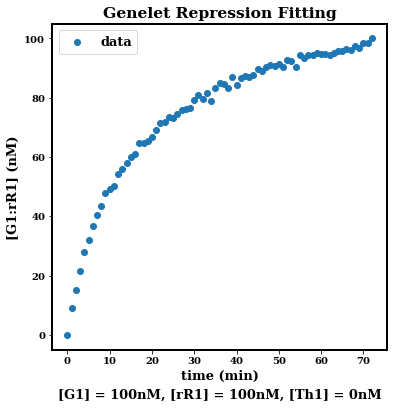

In [48]:
plt.scatter(range(len(data)), data, label = "data")
plt.xlabel("time (min)\n[G1] = 100nM, [rR1] = 100nM, [Th1] = 0nM", linespacing = 1.5, weight = "bold")
plt.ylabel("[G1:rR1] (nM)", weight = "bold")
plt.title("Genelet Repression Fitting", weight = "bold")
plt.legend()
plt.show()

---
#### Model

- **Components (y)**: **G1**, **rR1**, **Th1**, **G1rR1**, 


- **Rates (p)**: $K_{5bp} = \frac{1e^{5}}{1e^{9}} (\frac{1}{nM*s})$, $K_{6bp} = \frac{1e^{6}}{1e^{9}} (\frac{1}{nM*s})$


- **Reactions**:
    
    $ repression: rR1 + G1 \stackrel{k_{5bp}}{\rightarrow} G1:rR1 $
    
    $ competition: rR1 + Th1 \stackrel{k_{6bp}}{\rightarrow} Th1:rR1 $
    
    $ degradation: G1:rR1 \stackrel{k_{dds}}{\rightarrow} G1 $
    
    $ degradation: Th1:rR1 \stackrel{k_{dds}}{\rightarrow} Th1 $


- **ODEs**:
    
    $\frac{d[G1]}{dt}=-k_{5bp}[G1][rR1]$
    
    $\frac{d[G1:rR1]}{dt}=k_{5bp}[G1][rR1]$
    
    $\frac{d[rR1]}{dt}=-k_{5bp}[G1][rR1]-k_{6bp}[Th1][rR1]$
    
    $\frac{d[Th1]}{dt}=-k_{6bp}[Th1][rR1]$
    
    $\frac{d[Th1:rR1]}{dt}=k_{6bp}[Th1][rR1]$

    

In [33]:
from symfit import variables, parameters, ODEModel, D, Fit, Parameter
from symfit.core.support import key2str

tspan = np.arange(len(data)) * 60; fitting_data = np.array(data)

# Define our ODE model
t, G1, G1rR1, rR1, Th1, Th1rR1 = variables('t, G1, G1rR1, rR1, Th1, Th1rR1')
# Kp, K7bp = parameters('Kp, K7bp')
K5bp = Parameter('K5bp', value = 1e5/1e9, min = 1e3/1e9, max = 1e7/1e9)
K6bp = Parameter('K6bp', value = 1e6/1e9, fixed = True)

model_dict = {
    D(G1, t): - K5bp * G1 * rR1,
    D(G1rR1, t): K5bp * G1 * rR1,
    D(rR1, t): - K5bp * G1 * rR1 - K6bp * Th1 * rR1,
    D(Th1, t): - K6bp * Th1 * rR1,
    D(Th1rR1, t): K6bp * Th1 * rR1,
}

model = ODEModel(
    model_dict,
    initial = {t: 0.0, G1: 100.0, G1rR1: 0.0, rR1: 100.0, Th1: 0.0, Th1rR1: 0.0}
)

fit = Fit(model, t = tspan, G1 = None, G1rR1 = fitting_data, rR1 = None, Th1 = None, Th1rR1 = None) 
fit_result = fit.execute()

In [36]:
def sender_reviever_model(init_vals, params, t):
    """
    ode model for G2R1 ---| G1S1.
    """
    G20, G10, rR10, Th10, G1rR10, Th1rR10 = init_vals
    G2, G1, rR1, Th1, G1rR1, Th1rR1 = [G20], [G10], [rR10], [Th10], [G1rR10], [Th1rR10]
    Kp, K5bp, K6bp, Kdds = params
    dt = t[1] - t[0]
    for _ in t[1:]:
        dG2 = G2[-1]
        
        dG1 = G1[-1] + (- K5bp*G1[-1]*rR1[-1] + Kdds*G1rR1[-1]) * dt
        if dG1 > G10: dG1 = G10
        if dG1 < 0: dG1 = 0
        
        dG1rR1 = G1rR1[-1] + (K5bp*G1[-1]*rR1[-1] - Kdds*G1rR1[-1]) * dt
        if dG1rR1 > G10: dG1rR1 = G10
        if dG1rR1 < 0: dG1rR1 = 0
        
        drR1 = rR1[-1] + (Kp*G2[-1] - K5bp*G1[-1]*rR1[-1] - K6bp*Th1[-1]*rR1[-1]) * dt
        
        dTh1 = Th1[-1] + (Kdds*Th1rR1[-1] - K6bp*Th1[-1]*rR1[-1]) * dt
        if dTh1 > Th10: dTh1 = Th10
        if dTh1 < 0: dTh1 = 0
        
        dTh1rR1 = Th1rR1[-1] +  (- Kdds*Th1rR1[-1] + K6bp*Th1[-1]*rR1[-1]) * dt
        if dTh1rR1 > Th10: dTh1rR1 = Th10
        if dTh1rR1 < 0: dTh1rR1 = 0
        
        G2.append(dG2); G1.append(dG1); G1rR1.append(dG1rR1); rR1.append(drR1); Th1.append(dTh1); Th1rR1.append(dTh1rR1);
        
    return np.stack([G2, G1, rR1, Th1, G1rR1, Th1rR1]).T



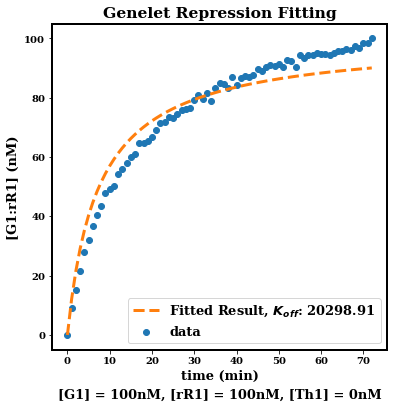

In [47]:
# G20 = 0nM, G10 = 100nM, rR10 = 100, Th10 = 0, G1rR10 = 0, Th1rR10 = 0
init_vals = [0, 100, 100, 0, 0, 0]

# Kp = 0. (1/s), K5bp = 1e5/1e9(1/nM/s), K6bp = 1e6/1e9(1/nM/s), Kdds = 0.0003(1/s)
params = [0., fit_result.value(K5bp), 1e6/1e9, 0.]

# 1 hr = 60 min = 3600sec
timestamp = np.arange(60 * 60 * 1)

simulation = sender_reviever_model(init_vals, params, tspan)

plt.plot(simulation[:,-2], ls = "--", label = "Fitted Result, $K_{off}$: "+"{:.2f}".format(fit_result.value(K5bp)*1e9), color = cm.colors[2])
plt.scatter(range(len(data)), data, label = "data", color = cm.colors[0])
plt.xlabel("time (min)\n[G1] = 100nM, [rR1] = 100nM, [Th1] = 0nM", linespacing = 1.5, weight = "bold")
plt.ylabel("[G1:rR1] (nM)", weight = "bold")
plt.title("Genelet Repression Fitting", weight = "bold")
plt.legend()
plt.show()

#### Result
 - Off rate = 2e4 (1/M/s), close to 4bp strand displacement rate (instead of expected 5bp rate).

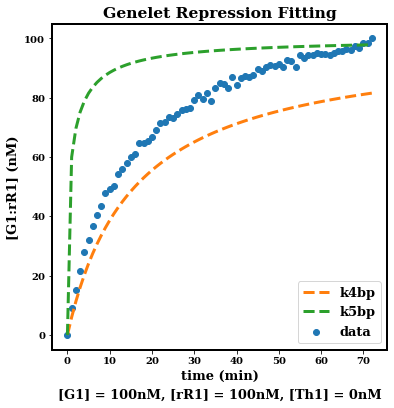

In [49]:
# G20 = 0nM, G10 = 100nM, rR10 = 100, Th10 = 0, G1rR10 = 0, Th1rR10 = 0
init_vals = [0, 100, 100, 0, 0, 0]

# Kp = 0. (1/s), K5bp = 1e5/1e9(1/nM/s), K6bp = 1e6/1e9(1/nM/s), Kdds = 0.0003(1/s)
params = [0., 1e4/1e9, 1e6/1e9, 0.]

# 1 hr = 60 min = 3600sec
timestamp = np.arange(60 * 60 * 1)

simulation = sender_reviever_model(init_vals, params, tspan)

plt.plot(simulation[:,-2], ls = "--", label = "k4bp", color = cm.colors[2])

# G20 = 0nM, G10 = 100nM, rR10 = 100, Th10 = 0, G1rR10 = 0, Th1rR10 = 0
init_vals = [0, 100, 100, 0, 0, 0]

# Kp = 0. (1/s), K5bp = 1e5/1e9(1/nM/s), K6bp = 1e6/1e9(1/nM/s), Kdds = 0.0003(1/s)
params = [0., 1e5/1e9, 1e6/1e9, 0.]

# 1 hr = 60 min = 3600sec
timestamp = np.arange(60 * 60 * 1)

simulation = sender_reviever_model(init_vals, params, tspan)

plt.plot(simulation[:,-2], ls = "--", label = "k5bp", color = cm.colors[4])

plt.scatter(range(len(data)), data, label = "data", color = cm.colors[0])
plt.xlabel("time (min)\n[G1] = 100nM, [rR1] = 100nM, [Th1] = 0nM", linespacing = 1.5, weight = "bold")
plt.ylabel("[G1:rR1] (nM)", weight = "bold")
plt.title("Genelet Repression Fitting", weight = "bold")
plt.legend()
plt.show()